# Agent based model of infection spread
### Author: Kirill Zakharov

In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interactive
import numpy as np
import random
from random import uniform
from math import sqrt
import matplotlib.pyplot as plt
from IPython.display import display
from enum import Enum
%matplotlib inline

In [48]:
np.random.seed(10)

class Status(Enum):
    """
    Agent status
    """
    Suspicious = 's'
    Infected = 'i'
    Healthy = 'h'

class Immunity(Enum):
    """
    Agent immunity to infection
    """
    High_Immunity = 'hi'
    Middle_Immunity = 'mi'
    Low_Immunity = 'li'
    
class Agent:

    def __init__(self, **kwargs):
        self.status = kwargs.get("status", Status.Suspicious) #one from three possible status
        self.immunity = kwargs.get("immunity", Immunity.Middle_Immunity) #one from three possible immunity
        self.x = kwargs.get("x", 0.1) #postition X
        self.y = kwargs.get("y", 0.1) #position Y
        self.k = kwargs.get("k", 5) #the number of contacts
        self.age = kwargs.get("age", 30) #age of the agent
        self.death_limit = random.randint(80, 100)
        self.location = (self.x, self.y)
        self.isolated = []
        self.inf_prec = 50
        self.home_s = True
        self.time = 0
        

    def change_location(self):
        self.x, self.y = round(uniform(0, 1),4), round(uniform(0, 1),4)
        self.location = (self.x, self.y)

    def _distance(self, other):
        return sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    

    def near_people(self, agents): #find the near k people 
        distances = []
        for agent in agents[:self.k]:
            if self != agent:
                dist = self._distance(agent)
                distances.append((dist, agent))
        distances.sort(key=lambda x: x[0])
        nears = [(d, agent) for d, agent in distances] #sorted by the distances

        return nears
    
    def home_status(self, time):
        #determine the home time
        if time < 9 or time > 21:
            return True
        else:
            return False
    
    def test_infection(self): #this function only for suspicious agents, checks for infection
        test_infection = random.randint(0, 100)
        if test_infection >= self.inf_prec:
            return True #if the test is positive
        else:
            return False
    
    def inf_check(self, delta, agents): #if the distance less than delta the agent is infected
        nears = self.near_people(agents)
        for near in nears:
            if near[0] <= delta and self.immunity.value == 'li':
                self.status = Status.Infected
                
            elif near[0] <= delta and self.immunity.value == 'mi':
                if self.status.value == 'h':
                    self.status = Status.Suspicious
                elif self.status.value == 's':
                    self.status = Status.Infected
                else:
                    return
                
            elif near[0] <= delta and self.immunity.value == 'hi':
                if self.status.value == 'h':
                    self.immunity = Immunity.Middle_Immunity
                elif self.status.value == 's':
                    self.immunity = Immunity.Low_Immunity
                else:
                    return
            elif near[0] > delta and self.immunity.value == 'hi' and self.test_infection():
                if self.status.value == 's':
                    self.status = Status.Healthy
                else:
                    return
            else:
                return
        return
    
    def move(self, delta, population): #the main function for moving on the map
        self.time += 1
        self.home_s = self.home_status(self.time)
        self.change_location()
        self.inf_check(delta, population)
        if self.status.value == 's' and self not in self.isolated and self.home_s:
            if self.test_infection():
                self.status = Status.Infected
            else:
                self.isolated.append(self)
        if self.status.value == 'i':
            if self.age > self.death_limit and self.immunity.value == 'li': #condition for death
                population.remove(self)
            elif self.age > self.death_limit and self.immunity.value == 'hi' and self not in self.isolated:
                self.isolated.append(self)
            else: return    

class Environmental(Agent):
    day = 24        

def create_agent(population, status): #function for creating one agent
        """
        Create a new agent
        """
        x, y = round(uniform(0, 1),4), round(uniform(0, 1),4) #position
        age = random.randint(1, 100) #age
        k = random.randint(0, 40) #the number of contacts
        immunity = random.choice([Immunity.High_Immunity, Immunity.Middle_Immunity, Immunity.Low_Immunity])
        
        population.append(Agent(x=x, y=y, age=age, k=k, status=status, immunity=immunity))
        return
        
def initialize(population, num_p, num_inf): #create the population
        # Initial infected population
        for _ in range(num_p*num_inf//100):
            create_agent(population, Status.Infected)

        # Initial healthy population
        for _ in range((num_p - len(population))//2):
            create_agent(population, Status.Healthy)

        # Initial suspicious population
        for _ in range(num_p - len(population)):
            create_agent(population, Status.Suspicious)
        
        return
        

    

In [49]:
num_p = 2000 #the number of people in population
population = []
delta = 0.05 #velocity of the infection spread
num_inf = 20 #the beginning percent of infected people

initialize(population, num_p, num_inf) #creating the population
len(population)

2000

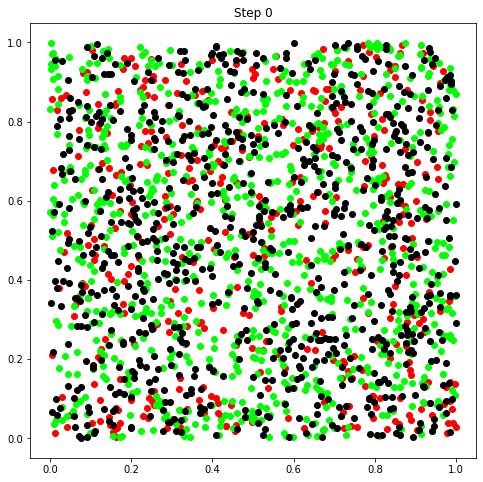

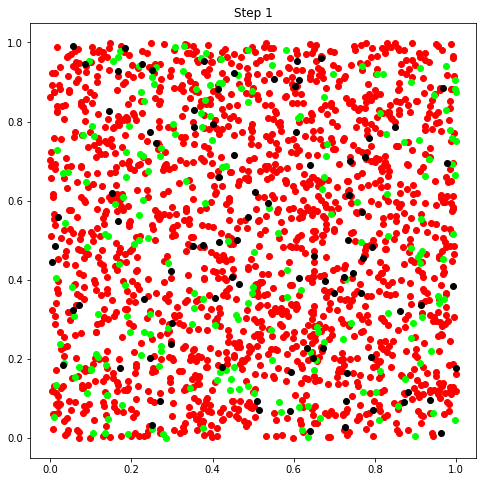

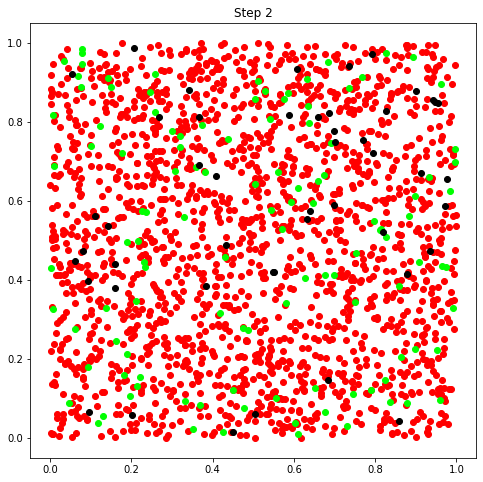

In [50]:
def plot_distribution(population, cycle_num):
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    x_values_2, y_values_2 = [], []
    for agent in population:
        x, y = agent.location
        if agent.status.value == 'i':
            x_values_0.append(x)
            y_values_0.append(y)
        elif agent.status.value == 'h':
            x_values_1.append(x)
            y_values_1.append(y)
        else:
            x_values_2.append(x)
            y_values_2.append(y)
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_args = {'markersize': 6, 'alpha': 1}
    ax.set_facecolor('white')
    ax.plot(x_values_0, y_values_0, 'o', c='red', **plot_args)
    ax.plot(x_values_1, y_values_1, 'o', c='lime', **plot_args)
    ax.plot(x_values_2, y_values_2, 'o', c='black', **plot_args)
    ax.set_title(f'Step {cycle_num-1}')
    plt.show()

count = 1

while True:
    healthy = []
    for agent in population:
        if agent.status.value == 'h' and agent not in healthy:
            healthy.append(agent)
    if len(healthy) >= ((num_p - num_inf)//2)*10//100:
        plot_distribution(population, count)
        count += 1
        for _ in range(Environmental.day):
            for agent in population:
                agent.move(delta, population)
    else:
        break
            

In [32]:
num_p-len(population) #the number of deaths

62

In [33]:
len(healthy)

97